In [1]:
import sys
import os
sys.path.insert(0,'../classes')
sys.path.insert(0,'../analysis')
import anl

sys.path.insert(0,'/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new')
hqfd = '/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new/Heuristic quality'
sys.path.insert(0,hqfd)
from fourinarowfunctions import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import logging
import numpy as np

import coloredlogs

from arena import Arena
from coach import Coach
from beck.beck_game import BeckGame as Game
from beck.beck_nnet import NNetWrapper as nn
from beck.beck_players import HumanBeckPlayer
from mcts import MCTS
from utils import *
log = logging.getLogger(__name__)

from keras import backend as K

# import tournament
# participant_iters = tournament.participant_iters

import load
import plot_fun
from importlib import reload
reload(load)

import value_analysis as va
import pandas as pd
import create_database as cd
import derived_metrics as dm
import tournament_new as tn

import copy
import seaborn as sns

import pingouin as pg

fig_save_dir = 'final_figures/'

{'mcts100_cpuct1': [1, 2, 3, 4, 6, 7, 9, 11, 12, 16, 18, 21, 25, 28, 29, 30, 37, 38, 39, 45, 47], 'mcts100_cpuct2': [1, 2, 3, 4, 6, 8, 12, 14, 15, 16, 21, 22, 24, 26, 27, 30, 32, 35, 39], 'mcts100_cpuct3': [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 16, 17, 18, 20, 21, 25, 26, 28, 32, 34, 35, 36], 'mcts25_cpuct1': [1, 2, 3, 4, 9, 11, 13, 14, 16, 19, 22, 25, 28, 29, 31, 37, 39, 45, 59, 61], 'mcts50_cpuct1': [1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 17, 18, 20, 21, 23, 25, 28, 29, 31, 37, 39, 41, 44, 45, 47, 48, 53], 'mcts80_cpuct1': [1, 2, 3, 4, 5, 7, 8, 9, 10, 13, 16, 19, 20, 21, 23, 24, 28, 34, 35, 36, 40], 'mcts80_cpuct2': [1, 2, 5, 6, 8, 10, 12, 13, 15, 17, 18, 19, 22, 25, 28, 30, 31, 34, 37, 38, 39, 40, 43, 45, 46, 51], 'mcts80_cpuct3': [1, 2, 5, 6, 7, 9, 12, 13, 14, 19, 21, 22, 23, 24, 26, 27, 28, 35, 36, 42, 43, 47, 49, 50, 51, 53, 54, 55, 56, 57]}
189 participant iterations!
510 participants for derived metrics


In [2]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from patsy import dmatrix,dmatrices

In [29]:
all_p_dm_join_relevant = dm.load_relevant_p_metric()

In [231]:
# all_p_dm_join_relevant = dm.add_sgd_iter(all_p_dm_join_relevant)

In [30]:
# max_sgd_iter = all_p_dm_join_relevant.groupby('model_line')['value_func_sgd_iter'].max().min()
max_iter = all_p_dm_join_relevant.groupby('model_line')['value_func_iter'].max().min()
all_p_dm_join_relevant_samemaxiter=all_p_dm_join_relevant.loc[all_p_dm_join_relevant['value_func_iter']<max_iter]



In [28]:
# # update 
# METRIC_DATABASE_LOC = dm.METRIC_DATABASE_LOC
# METRIC_RES_DIR = dm.METRIC_RES_DIR
# dm_db_df = pd.read_pickle(METRIC_DATABASE_LOC)
# new_metrics = ['depth','entropy','depth_ratio']
# for k in new_metrics:
#     dm_db_df['{k};mean']=np.nan
#     dm_db_df['{k};sem']=np.nan
# for id in dm.participants.id:
#     tosave_folder = ';'.join(id.split(';')[:-1]) # get rid of iter, keep the rest to make a folder
#     tosave_folder_full = os.path.join(METRIC_RES_DIR, tosave_folder)
#     fn_board = f'depth_entropy_board_{id}.p'
#     fn_board = os.path.join(tosave_folder_full,fn_board)
#     try:
#         board_res_df = pd.read_pickle(fn_board)
#         for k in new_metrics:
#             dm_db_df.loc[id,f'{k};mean']=board_res_df[k].mean()
#             dm_db_df.loc[id,f'{k};sem']=board_res_df[k].sem()
#     except:
#         print(f'no derived metric for {id}')
# dm_db_df.to_pickle(METRIC_DATABASE_LOC)
# print('metric db updated!')

metric db updated!


In [31]:
def get_design_matrix(data,endog,exog_cont,exog_cat,**kwargs):
    
    exog_cont = [f"Q('{ex}')" if ';' in ex else ex for ex in exog_cont]
    exog_cat = [f"C(Q('{ex}'))" if ';' in ex else f'C({ex})' for ex in exog_cat]
    exog_all = exog_cont + exog_cat
#     exog_all = [f'standardize({ex})' for ex in exog_all]
    exog_str = '+'.join(exog_all)
    formula = f'{endog}~{exog_str}'
    dmat = dmatrices(formula,data)

#     return formula
#     if dmat[1][:,1:].shape[1] > 1:
    exog_mat = (dmat[1][:,1:] - dmat[1][:,1:].mean(axis=0,keepdims=True))/dmat[1][:,1:].std(axis=0,keepdims=True)
#     else:
#         exog_mat = (dmat[1][:,1:] - dmat[1][:,1:].mean())/dmat[1][:,1:].std()
    exog_df = pd.DataFrame(exog_mat,columns=dmat[1].design_info.column_names[1:])
    endog_mat = (dmat[0] - dmat[0].mean())/dmat[0].std()
    endog_df = pd.DataFrame(endog_mat,columns=dmat[0].design_info.column_names)
    return endog_df,exog_df

def regress(df,endog,exog_cont,exog_cat,**kwargs):
    endog_df,exog_df = get_design_matrix(df, endog=endog,exog_cont=exog_cont,exog_cat=exog_cat)
    model=sm.OLS(endog=endog_df,exog=exog_df)
    if 'regularized' in kwargs.keys():
        regularized = kwargs['regularized']
    else:
        regularized = False
    if 'alpha' in kwargs.keys():
        alpha = kwargs['alpha']
    else:
        alpha = 0.001
    if 'L1_wt' in kwargs.keys():
        L1_wt = kwargs['L1_wt']
    else:
        L1_wt = 1
    if regularized:
        res=model.fit_regularized(alpha=alpha,L1_wt=L1_wt)
        print(res.params)

    else:
        res=model.fit()
        print(res.summary())
    return res,endog_df,exog_df

def resid_regress(df,regress_dict_1,regress_dict_2,**kwargs):
    print('first regression\n')
    res1,endog_df1,exog_df1 = regress(df,**regress_dict_1)

    df_copy = copy.copy(df)
    df_copy['resid']=res1.resid.values

    print('second regression\n')
    regress_dict_2['endog'] = 'resid'
    print('regression on residual\n')
    res2,endog_df2,exog_df2 = regress(df_copy,**regress_dict_2)

    return res1,res2,endog_df1,exog_df1,endog_df2,exog_df2
    
    
    

In [33]:
all_p_dm_join_relevant[['elo','depth;median','value_func_quality','value_func_iter']].pcorr()

,elo,depth;median,value_func_quality,value_func_iter
elo,1.000000,0.420846,0.662671,0.001617
depth;median,0.420846,1.000000,0.076229,0.406211
value_func_quality,0.662671,0.076229,1.000000,0.278328
value_func_iter,0.001617,0.406211,0.278328,1.000000


In [32]:
all_p_dm_join_relevant[['elo','depth;mean','value_func_quality','value_func_iter']].pcorr()

,elo,depth;mean,value_func_quality,value_func_iter
elo,1.000000,0.474872,0.705861,-0.056530
depth;mean,0.474872,1.000000,-0.066029,0.461350
value_func_quality,0.705861,-0.066029,1.000000,0.330984
value_func_iter,-0.056530,0.461350,0.330984,1.000000


In [213]:
# def map_id_to_model_line(id):
#     if ';' in id:
#         id_split = id.split(';')
#         if id_split[-1].isnumeric() or id_split[-1]=='best':
#             model_line = ';'.join(id_split[:-1])
#             return model_line
#         else:
#             return None
#     else:
#         return None
        
# # all_p['model_line']=all_p['id'].apply(map_id_to_model_line)

# elo vs iter + hyperparams

In [367]:
endog = 'elo'
# exog_cont = ['value_func_sgd_iter','depth;median','value_func_quality']
exog_cont = ['value_func_iter']
exog_cat = ['n_res','dir_alpha','tempThreshold','color','cpuct','continuous_training']
# regress(all_p_dm_join_relevant, endog=endog,exog_cont=exog_cont,exog_cat=exog_cat,regularized=True,alpha=0.001,L1_wt=1)
_=regress(all_p_dm_join_relevant, endog=endog,exog_cont=exog_cont,exog_cat=exog_cat)


                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.648
Model:                            OLS   Adj. R-squared (uncentered):              0.642
Method:                 Least Squares   F-statistic:                              112.5
Date:                Thu, 27 Jan 2022   Prob (F-statistic):                   1.00e-105
Time:                        20:13:27   Log-Likelihood:                         -445.84
No. Observations:                 497   AIC:                                      907.7
Df Residuals:                     489   BIC:                                      941.3
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [368]:
endog = 'elo'
# exog_cont = ['value_func_sgd_iter','depth;median','value_func_quality']
exog_cont = ['value_func_iter']
exog_cat = ['n_res','dir_alpha','tempThreshold','color','cpuct','continuous_training']
# regress(all_p_dm_join_relevant, endog=endog,exog_cont=exog_cont,exog_cat=exog_cat,regularized=True,alpha=0.001,L1_wt=1)
_=regress(all_p_dm_join_relevant_samemaxiter, endog=endog,exog_cont=exog_cont,exog_cat=exog_cat)


                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.769
Model:                            OLS   Adj. R-squared (uncentered):              0.763
Method:                 Least Squares   F-statistic:                              134.7
Date:                Thu, 27 Jan 2022   Prob (F-statistic):                    2.90e-98
Time:                        20:13:28   Log-Likelihood:                         -227.91
No. Observations:                 332   AIC:                                      471.8
Df Residuals:                     324   BIC:                                      502.3
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

# elo vs depth + value

In [34]:
endog = 'elo'
# exog_cont = ['depth;median','value_func_quality']
exog_cont = ['depth;mean','value_func_quality']
# exog_cont = ['value_func_sgd_iter']
exog_cat = []#['n_res','dir_alpha','tempThreshold','color']
# regress(all_p_dm_join_relevant, endog=endog,exog_cont=exog_cont,exog_cat=exog_cat,regularized=True,alpha=0.001,L1_wt=1)
_=regress(all_p_dm_join_relevant, endog=endog,exog_cont=exog_cont,exog_cat=exog_cat)


                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              1725.
Date:                Fri, 28 Jan 2022   Prob (F-statistic):                   7.52e-224
Time:                        10:14:02   Log-Likelihood:                         -189.38
No. Observations:                 497   AIC:                                      382.8
Df Residuals:                     495   BIC:                                      391.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [370]:
endog = 'elo'
exog_cont = ['depth;median','value_func_quality']
# exog_cont = ['value_func_sgd_iter']
exog_cat = []#['n_res','dir_alpha','tempThreshold','color']
# regress(all_p_dm_join_relevant, endog=endog,exog_cont=exog_cont,exog_cat=exog_cat,regularized=True,alpha=0.001,L1_wt=1)
_=regress(all_p_dm_join_relevant_samemaxiter, endog=endog,exog_cont=exog_cont,exog_cat=exog_cat)


                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.833
Model:                            OLS   Adj. R-squared (uncentered):              0.832
Method:                 Least Squares   F-statistic:                              821.1
Date:                Thu, 27 Jan 2022   Prob (F-statistic):                   7.75e-129
Time:                        20:14:52   Log-Likelihood:                         -174.31
No. Observations:                 332   AIC:                                      352.6
Df Residuals:                     330   BIC:                                      360.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

# elo - iter vs depth + value

In [35]:
regress_dict_1 = {'endog':'elo','exog_cont':['value_func_iter'],'exog_cat':[]}
# regress_dict_2 = {'exog_cont':['depth;median','value_func_quality'],'exog_cat':[]}
regress_dict_2 = {'exog_cont':['depth;mean','value_func_quality'],'exog_cat':[]}
res1,res2,_,_,_,_=resid_regress(all_p_dm_join_relevant, regress_dict_1, regress_dict_2)


first regression

                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.606
Model:                            OLS   Adj. R-squared (uncentered):              0.605
Method:                 Least Squares   F-statistic:                              763.5
Date:                Fri, 28 Jan 2022   Prob (F-statistic):                   1.97e-102
Time:                        10:14:18   Log-Likelihood:                         -473.64
No. Observations:                 497   AIC:                                      949.3
Df Residuals:                     496   BIC:                                      953.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [372]:
regress_dict_1 = {'endog':'elo','exog_cont':['value_func_iter'],'exog_cat':[]}
regress_dict_2 = {'exog_cont':['depth;median','value_func_quality'],'exog_cat':[]}
res1,res2,_,_,_,_=resid_regress(all_p_dm_join_relevant_samemaxiter, regress_dict_1, regress_dict_2)


first regression

                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.731
Model:                            OLS   Adj. R-squared (uncentered):              0.730
Method:                 Least Squares   F-statistic:                              900.9
Date:                Thu, 27 Jan 2022   Prob (F-statistic):                    1.78e-96
Time:                        20:15:47   Log-Likelihood:                         -252.93
No. Observations:                 332   AIC:                                      507.9
Df Residuals:                     331   BIC:                                      511.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------

# elo - iter vs depth + value + (dir_alpha + tempThreshold ) 
the combo of these hyperparam make depth significant, otherwise not significant; 
- so when dir_alpha=0.03, even increasing depth wouldn't help; otherwise would help;

In [36]:
regress_dict_1 = {'endog':'elo','exog_cont':['value_func_iter'],'exog_cat':[]}
# regress_dict_2 = {'exog_cont':['depth;median','value_func_quality'],'exog_cat':['dir_alpha','tempThreshold']}
regress_dict_2 = {'exog_cont':['depth;mean','value_func_quality'],'exog_cat':['dir_alpha','tempThreshold']}
res1,res2,_,_,_,_=resid_regress(all_p_dm_join_relevant, regress_dict_1, regress_dict_2)


first regression

                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.606
Model:                            OLS   Adj. R-squared (uncentered):              0.605
Method:                 Least Squares   F-statistic:                              763.5
Date:                Fri, 28 Jan 2022   Prob (F-statistic):                   1.97e-102
Time:                        10:16:38   Log-Likelihood:                         -473.64
No. Observations:                 497   AIC:                                      949.3
Df Residuals:                     496   BIC:                                      953.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [383]:
res1,res2,_,_,_,_=resid_regress(all_p_dm_join_relevant_samemaxiter, regress_dict_1, regress_dict_2)


first regression

                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.731
Model:                            OLS   Adj. R-squared (uncentered):              0.730
Method:                 Least Squares   F-statistic:                              900.9
Date:                Thu, 27 Jan 2022   Prob (F-statistic):                    1.78e-96
Time:                        20:21:47   Log-Likelihood:                         -252.93
No. Observations:                 332   AIC:                                      507.9
Df Residuals:                     331   BIC:                                      511.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [56]:
cut_off_iter = hyperparams['max_iter'].min()
mask = (all_p_dm_join_relevant['value_func_iter'] >=cut_off_iter-3) & (all_p_dm_join_relevant['value_func_iter'] <=cut_off_iter+3)
hyperparams['elo_same_cutoff_iter']=all_p_dm_join_relevant.loc[mask].groupby('model_line')['elo'].mean()


In [57]:
gpb=all_p_dm_join_relevant.groupby('model_line')
hyperparams = gpb[['n_res','cpuct','color','continuous_training','dir_alpha','tempThreshold']].first().sort_values(['n_res','color','continuous_training','dir_alpha','cpuct','tempThreshold'])
hyperparams['max_iter'] = gpb['value_func_iter'].max()
hyperparams['max_iter'].min()
hyperparams['max_elo'] = gpb['elo'].max()
# hyperparams['mean_elo'] = gpb['elo'].mean()
cut_off_iter = hyperparams['max_iter'].min()
mask = (all_p_dm_join_relevant['value_func_iter'] >=cut_off_iter-3) & (all_p_dm_join_relevant['value_func_iter'] <=cut_off_iter+3)
hyperparams['elo_same_cutoff_iter']=all_p_dm_join_relevant.loc[mask].groupby('model_line')['elo'].mean()
# hyperparams= hyperparams.reset_index(drop=True)
hyperparams.sort_values('max_elo',ascending=False)


,n_res,cpuct,color,continuous_training,dir_alpha,tempThreshold,max_iter,max_elo,elo_same_cutoff_iter
model_line,,,,,,,,,
tournament_16;mcts100;cpuct2;id-res3-0,3,2.0,True,True,0.30,15,94,231.0,154.500000
tournament_8;mcts100;cpuct2e+00;id-res3-1,3,2.0,False,False,0.00,40,71,229.0,178.250000
tournament_13;mcts100;cpuct2;id-res3-0,3,2.0,True,True,0.03,15,97,224.0,116.000000
tournament_14;mcts100;cpuct2;id-res9-0,9,2.0,True,False,0.00,15,62,218.0,165.750000
tournament_12;mcts100;cpuct2;id-res3-0,3,2.0,True,False,0.03,15,95,206.0,118.666664
tournament_12;mcts100;cpuct2;id-res9-0,9,2.0,True,False,0.03,15,71,203.0,86.250000
tournament_14;mcts100;cpuct2;id-res3-0,3,2.0,True,False,0.00,15,89,197.0,124.000000
tournament_15;mcts100;cpuct2;id-res3-0,3,2.0,False,True,0.00,15,78,189.0,154.000000
tournament_8;mcts100;cpuct2;id-res9-0,9,2.0,False,False,0.00,15,57,185.0,163.500000


In [58]:
hyperparams.sort_values('elo_same_cutoff_iter',ascending=False)

,n_res,cpuct,color,continuous_training,dir_alpha,tempThreshold,max_iter,max_elo,elo_same_cutoff_iter
model_line,,,,,,,,,
tournament_8;mcts100;cpuct2e+00;id-res3-1,3,2.0,False,False,0.00,40,71,229.0,178.250000
tournament_8;mcts100;cpuct2;id-res3-0,3,2.0,False,False,0.00,15,43,178.0,175.500000
tournament_14;mcts100;cpuct2;id-res9-0,9,2.0,True,False,0.00,15,62,218.0,165.750000
tournament_8;mcts100;cpuct2;id-res9-0,9,2.0,False,False,0.00,15,57,185.0,163.500000
tournament_16;mcts100;cpuct2;id-res3-0,3,2.0,True,True,0.30,15,94,231.0,154.500000
tournament_15;mcts100;cpuct2;id-res3-0,3,2.0,False,True,0.00,15,78,189.0,154.000000
tournament_15;mcts100;cpuct2;id-res9-0,9,2.0,False,True,0.00,15,63,174.0,131.500000
tournament_14;mcts100;cpuct2;id-res3-0,3,2.0,True,False,0.00,15,89,197.0,124.000000
tournament_12;mcts100;cpuct2;id-res3-0,3,2.0,True,False,0.03,15,95,206.0,118.666664


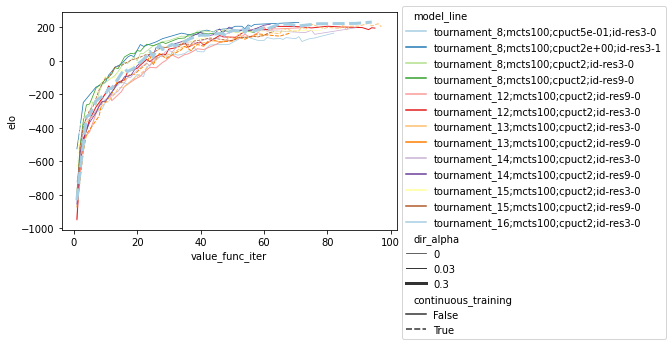

In [384]:
ax=sns.lineplot(x='value_func_iter',y='elo',data=all_p_dm_join_relevant,hue='model_line',palette='Paired',style='continuous_training',size='dir_alpha')
ax.legend_.set_bbox_to_anchor(bbox=[1,1.05])
# ax.figure

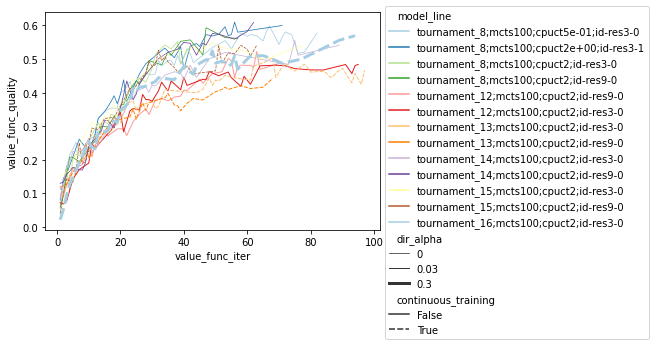

In [404]:
ax=sns.lineplot(x='value_func_iter',y='value_func_quality',data=all_p_dm_join_relevant,hue='model_line',palette='Paired',style='continuous_training',size='dir_alpha')
ax.legend_.set_bbox_to_anchor(bbox=[1,1.05])
# ax.figure

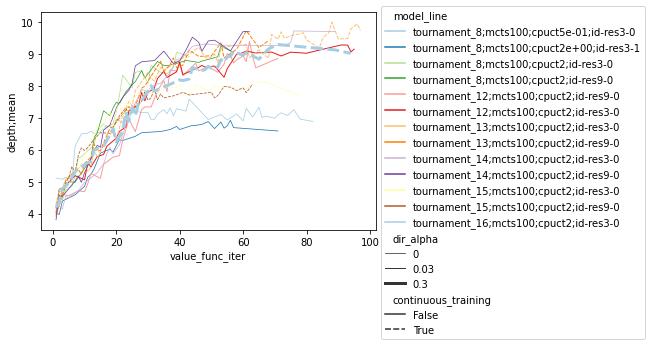

In [62]:
# ax=sns.lineplot(x='value_func_iter',y='depth;median',data=all_p_dm_join_relevant,hue='model_line',palette='Paired',style='continuous_training',size='dir_alpha')
ax=sns.lineplot(x='value_func_iter',y='depth;mean',data=all_p_dm_join_relevant,hue='model_line',palette='Paired',style='continuous_training',size='dir_alpha')
ax.legend_.set_bbox_to_anchor(bbox=[1,1.05])
# ax.figure

<AxesSubplot:xlabel='depth;median', ylabel='elo'>

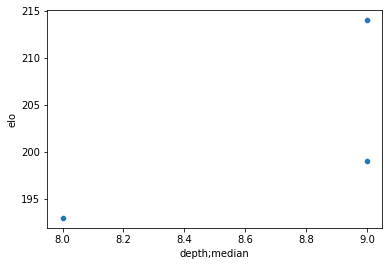

In [432]:
n=80
mask = (all_p_dm_join_relevant.value_func_sgd_iter>=n) &(all_p_dm_join_relevant.value_func_sgd_iter<=n+5)
sns.scatterplot(data=all_p_dm_join_relevant.loc[mask],x='depth;median',y='elo')

# partition in agent strength

In [64]:
reg_df_partitioned.corr()

,other_type,value_func_iter,value_func_quality,depth;median,depth_ratio;median,entropy;median,elo,value_func_quality_stddz,depth;median_stddz
other_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
value_func_iter,NaN,1.000000,0.797359,0.813645,0.816972,-0.823220,0.778579,0.797359,0.813645
value_func_quality,NaN,0.797359,1.000000,0.832164,0.869471,-0.929281,0.911712,1.000000,0.832164
depth;median,NaN,0.813645,0.832164,1.000000,0.977036,-0.911939,0.863780,0.832164,1.000000
depth_ratio;median,NaN,0.816972,0.869471,0.977036,1.000000,-0.933230,0.884157,0.869471,0.977036
entropy;median,NaN,-0.823220,-0.929281,-0.911939,-0.933230,1.000000,-0.946583,-0.929281,-0.911939
elo,NaN,0.778579,0.911712,0.863780,0.884157,-0.946583,1.000000,0.911712,0.863780
value_func_quality_stddz,NaN,0.797359,1.000000,0.832164,0.869471,-0.929281,0.911712,1.000000,0.832164
depth;median_stddz,NaN,0.813645,0.832164,1.000000,0.977036,-0.911939,0.863780,0.832164,1.000000


In [ ]:
import pingouin

In [72]:
all_p_dm_join_relevant['elo'].mean()

-5.004024

In [71]:
regress_dict_1 = {'endog':'elo','exog_cont':['value_func_iter'],'exog_cat':[]}
# regress_dict_2 = {'exog_cont':['depth;median','value_func_quality'],'exog_cat':[],'regularized':True,'alpha':0.09,'L1_wt':1}
# regress_dict_2 = {'exog_cont':['depth;median','value_func_quality'],'exog_cat':[]}
# regress_dict_2 = {'endog':'elo','exog_cont':['depth;mean','value_func_quality'],'exog_cat':[]}
regress_dict_2 = {'endog':'elo','exog_cont':['depth;median','value_func_quality'],'exog_cat':[]}


N_agents = all_p_dm_join_relevant.shape[0]
n = 3
partition_pts = [(int(N_agents/n * k), int(N_agents/n * (k+1))) for k in range(n)]
reg_df_partitioned_l = []
for (beg,end) in partition_pts:
    reg_df_partitioned_l.append(all_p_dm_join_relevant.sort_values('elo').iloc[beg:end])
for reg_df_partitioned in reg_df_partitioned_l:
    res1,res2,_,_,_,_=resid_regress(reg_df_partitioned, regress_dict_1, regress_dict_2)
#     _=regress(reg_df_partitioned, **regress_dict_2)
#     print(reg_df_partitioned[['elo','value_func_quality','depth;mean','value_func_iter']].pcorr())

first regression

                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.679
Model:                            OLS   Adj. R-squared (uncentered):              0.677
Method:                 Least Squares   F-statistic:                              347.3
Date:                Fri, 28 Jan 2022   Prob (F-statistic):                    2.43e-42
Time:                        11:43:53   Log-Likelihood:                         -140.32
No. Observations:                 165   AIC:                                      282.6
Df Residuals:                     164   BIC:                                      285.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [69]:
all_p_dm_join_relevant.sort_values('elo',ascending=False).id

1982       tournament_16;mcts100;cpuct2;id-res3-0;94
1970    tournament_8;mcts100;cpuct2e+00;id-res3-1;71
1772       tournament_13;mcts100;cpuct2;id-res3-0;93
1981       tournament_16;mcts100;cpuct2;id-res3-0;89
1980       tournament_16;mcts100;cpuct2;id-res3-0;77
                            ...                     
1911        tournament_16;mcts100;cpuct2;id-res3-0;1
1779        tournament_14;mcts100;cpuct2;id-res9-0;1
1689        tournament_13;mcts100;cpuct2;id-res9-0;1
1600        tournament_12;mcts100;cpuct2;id-res9-0;1
1601        tournament_12;mcts100;cpuct2;id-res3-0;1
Name: id, Length: 497, dtype: object

In [37]:
stddz = lambda x:(x-x.mean())/x.std()
all_p_dm_join_relevant['value_func_quality_stddz'] = stddz(all_p_dm_join_relevant['value_func_quality'].values)
all_p_dm_join_relevant['depth;median_stddz'] = stddz(all_p_dm_join_relevant['depth;median'].values)

In [41]:
partition_pts

[(0, 124), (124, 248), (248, 372), (372, 497)]

In [45]:
reg_df_partitioned.shape

(249, 33)

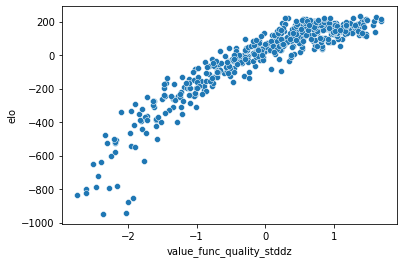

In [56]:
ax=sns.scatterplot(data=all_p_dm_join_relevant,x='value_func_quality_stddz',y='elo')
# ax.set_ylim([-700,200])


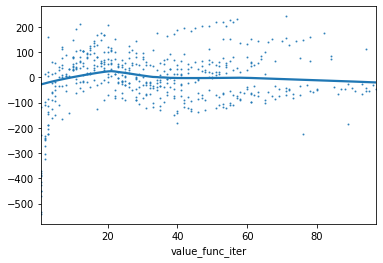

In [12]:
n = 1
N_agents = all_p_dm_join_relevant.shape[0]
partition_pts = [(int(N_agents/n * k), int(N_agents/n * (k+1))) for k in range(n)]

reg_df_partitioned_l = []
for (beg,end) in partition_pts:
    reg_df_partitioned_l.append(all_p_dm_join_relevant.sort_values('elo').iloc[beg:end])


for reg_df_partitioned in reg_df_partitioned_l:
#     sns.regplot(data=reg_df_partitioned,x='value_func_quality',y='elo',y_partial='value_func_iter',scatter_kws={'s':1})
#     ax=sns.regplot(data=reg_df_partitioned,x='value_func_quality_stddz',y='elo',y_partial='value_func_iter',scatter_kws={'s':1},lowess=True)
    ax=sns.regplot(data=reg_df_partitioned,x='value_func_iter',y='elo',y_partial='depth;median',scatter_kws={'s':1},lowess=True)
#     ax=sns.regplot(data=reg_df_partitioned,x='value_func_quality_stddz',y='elo',scatter_kws={'s':1},lowess=True)
    
# for reg_df_partitioned in reg_df_partitioned_l:
# #     sns.regplot(data=reg_df_partitioned,x='value_func_quality',y='elo',y_partial='value_func_iter',scatter_kws={'s':1})
#     ax=sns.regplot(data=reg_df_partitioned,x='depth;median_stddz',y='elo',y_partial='value_func_iter',scatter_kws={'s':1},lowess=True,ax=ax)
    
    

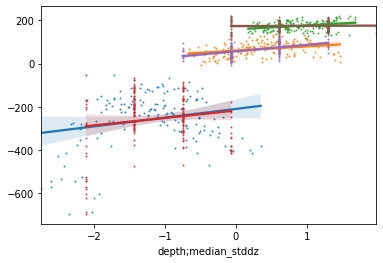

In [39]:
for reg_df_partitioned in reg_df_partitioned_l:
    ax=sns.regplot(data=reg_df_partitioned,x='depth;median_stddz',y='elo',y_partial='value_func_iter',scatter_kws={'s':1},ax=ax)
    

ax.figure

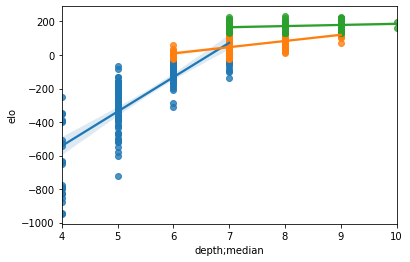

In [11]:
for reg_df_partitioned in reg_df_partitioned_l:
    sns.regplot(data=reg_df_partitioned,x='depth;median',y='elo')

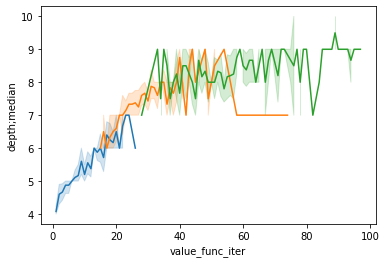

In [10]:
for reg_df_partitioned in reg_df_partitioned_l:
    sns.lineplot(data=reg_df_partitioned,x='value_func_iter',y='depth;median')

In [395]:
N_agents = all_p_dm_join_relevant_samemaxiter.shape[0]
n = 4
partition_pts = [(int(N_agents/n * k), int(N_agents/n * (k+1))) for k in range(n)]
reg_df_partitioned_l = []
for (beg,end) in partition_pts:
    reg_df_partitioned_l.append(all_p_dm_join_relevant_samemaxiter.sort_values('elo').iloc[beg:end])
for reg_df_partitioned in reg_df_partitioned_l:
    res1,res2,_,_,_,_=resid_regress(reg_df_partitioned, regress_dict_1, regress_dict_2)


first regression

                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.625
Model:                            OLS   Adj. R-squared (uncentered):              0.620
Method:                 Least Squares   F-statistic:                              136.5
Date:                Thu, 27 Jan 2022   Prob (F-statistic):                    3.92e-19
Time:                        20:34:59   Log-Likelihood:                         -77.104
No. Observations:                  83   AIC:                                      156.2
Df Residuals:                      82   BIC:                                      158.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------

# partition by iter


In [407]:
regress_dict_1 = {'endog':'elo','exog_cont':['value_func_iter'],'exog_cat':[]}
regress_dict_2 = {'exog_cont':['depth;median','value_func_quality'],'exog_cat':[]}

max_iter = all_p_dm_join_relevant.value_func_iter.max()

n = 3
partition_pts = [(int(max_iter/n * k), int(max_iter/n * (k+1))) for k in range(n)]
reg_df_partitioned_l = []
for (beg,end) in partition_pts:
    print(f'{beg} to {end}')
    mask = (all_p_dm_join_relevant.value_func_iter >= beg) & (all_p_dm_join_relevant.value_func_iter <= end)
    reg_df_partitioned_l.append(all_p_dm_join_relevant.loc[mask])
    res1,res2,_,_,_,_=resid_regress(reg_df_partitioned_l[-1], regress_dict_1, regress_dict_2)


0 to 32
first regression

                                 OLS Regression Results                                
Dep. Variable:                    elo   R-squared (uncentered):                   0.750
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                              789.2
Date:                Thu, 27 Jan 2022   Prob (F-statistic):                    3.75e-81
Time:                        21:29:00   Log-Likelihood:                         -191.59
No. Observations:                 264   AIC:                                      385.2
Df Residuals:                     263   BIC:                                      388.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
----------

In [34]:
import statsmodels.stats as ss
from statsmodels.stats import outliers_influence
outliers_influence.variance_inflation_factor(model.exog,7)

6.062149202447658